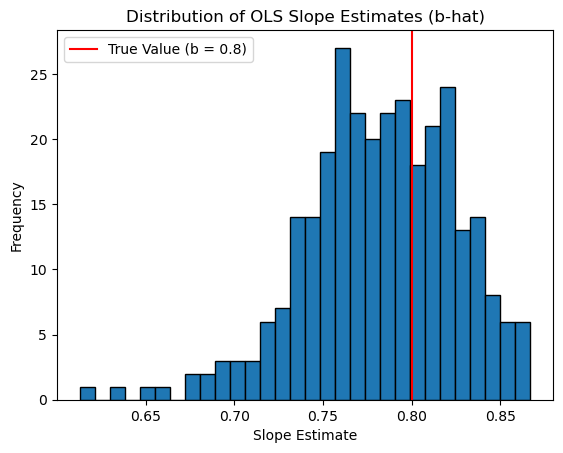

Fraction of estimates below true slope (b=0.8): 0.63
The fact that 63% of estimates are below the true value means that the estimates are not perfectly centered around 0.8; however, they generally tend to cluster around this value. This shows that while the OLS estimator is reliable, it still exhibits variability due to the random nature of the process.


In [20]:
#1 Generate a random sample following AR1 process

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

#Parameters 
X0 = 1
a = 2
b = 0.8
V = 1 #variance
n_obs = 400
n_simulations = 301

np.random.seed(123)

# Function to run an AR(1)
def ar1_process(n, a, b, X0, V):
    X = [X0] #making a list that we can append easily
    u = np.random.normal(0, np.sqrt(V), n) #random erros with mean 0 and std dev 
    for t in range(n):
        X_t = a + b * X[-1] + u[t] #x[-1] takes the most recent obs added to X
        X.append(X_t)
    return np.array(X[1:]) #exclude X0 - includes only the generated values of X

#Function to estimate slope from the AR(1)
def estimate_slope(X):
    X_sample = X[-200:] #keep only last 200 obs

    X_lag = X_sample[:-1] #All except last one
    X_current = X_sample[1:] #All except first one

    X_lag = sm.add_constant(X_lag) #add constant to the lagged values for the intercept term
    model = sm.OLS(X_current, X_lag).fit()
    return model.params[1] #return the slope coeff


#Monte Carlo Simulation
slope_estimates = [] #empty list to store estimates

#Loop through each simulation
for _ in range(n_simulations):
    X = ar1_process(n_obs, a, b, X0, V) #gen AR(1)
    b_hat = estimate_slope(X) #Estimate the slope
    slope_estimates.append(b_hat) #append the estimate to the list

slope_estimates = np.array(slope_estimates) #convert to numpy array

plt.hist(slope_estimates, bins=30, edgecolor='black')
plt.axvline(b, color = 'red', label = "True Value (b = 0.8)")
plt.title('Distribution of OLS Slope Estimates (b-hat)')
plt.xlabel('Slope Estimate')
plt.ylabel('Frequency')
plt.legend()
plt.show()

fraction_below_08 = np.mean(slope_estimates < b)
print(f"Fraction of estimates below true slope (b=0.8): {fraction_below_08:.2f}")

We see that 63% of estimates are below the true value, meaning estimates are not perfectly centered around 0.8; however, they do seem to generally cluster around the true slope, indicating the estimator is generally unbiased, but it exhibits some variability.


In [4]:
#Q2 

import numpy as np
import pandas as pd
import statsmodels.api as sm

# Load the data
data = np.loadtxt('/Users/spencerlove/Library/CloudStorage/OneDrive-TheUniversityofWesternOntario/MFE_Python/MFEcodonomics/Data/exdata.txt')

# Prepare the data for AR(2) model without the constant
X_t2 = data[2:]  # X_{t+2}
X_t1 = data[1:-1]  # X_{t+1}
X_t = data[:-2]  # X_t

# Stack X_t1 and X_t to create the predictor matrix (no constant)
X = np.column_stack((X_t1, X_t))

# Fit the OLS model without the intercept
model = sm.OLS(X_t2, X).fit()
a, b = model.params[0], model.params[1]
W = model.mse_resid

# Display the OLS estimates
print(f'Estimate of a: {a}')
print(f'Estimate of b: {b}')
print(f'Estimate of W (variance of residuals): {W}')

# Calculate the impulse response function for 5 periods after a unit shock
impulse_response = [1, a, a**2 + b, a**3 + 2*a*b, a**4 + 3*a**2*b + b**2]
print("Impulse Response Function (for 1 to 5 periods):", impulse_response)

# Parametric bootstrap for confidence intervals
np.random.seed(0)  # For reproducibility
n_bootstraps = 1000
bootstrap_estimates = np.zeros((n_bootstraps, 5))

for i in range(n_bootstraps):
    # Generate bootstrapped residuals and new response variable
    boot_residuals = np.random.normal(0, np.sqrt(W), size=len(X_t2))
    X_t2_boot = model.predict(X) + boot_residuals
    
    # Fit the model on the bootstrapped data without intercept
    boot_model = sm.OLS(X_t2_boot, X).fit()
    a_boot, b_boot = boot_model.params[0], boot_model.params[1]
    
    # Calculate impulse responses for bootstrapped estimates
    irf_boot = [
        1,
        a_boot,
        a_boot**2 + b_boot,
        a_boot**3 + 2*a_boot*b_boot,
        a_boot**4 + 3*a_boot**2*b_boot + b_boot**2
    ]
    
    bootstrap_estimates[i, :] = irf_boot

# Calculate 95% confidence intervals
ci_lower = np.percentile(bootstrap_estimates, 2.5, axis=0)
ci_upper = np.percentile(bootstrap_estimates, 97.5, axis=0)

# Display the confidence intervals
for period in range(5):
    print(f"95% CI for period {period + 1}: [{ci_lower[period]:.3f}, {ci_upper[period]:.3f}]")

Estimate of a: 0.70834546336437
Estimate of b: -0.11541745953966653
Estimate of W (variance of residuals): 0.9595826799504402
Impulse Response Function (for 1 to 5 periods): [1, 0.70834546336437, 0.3863358359292175, 0.19190380285757924, 0.091344287444453]
95% CI for period 1: [1.000, 1.000]
95% CI for period 2: [0.578, 0.844]
95% CI for period 3: [0.249, 0.554]
95% CI for period 4: [0.043, 0.369]
95% CI for period 5: [-0.034, 0.250]
